In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored
from src.load_data import load_datasets,load_dataframe
from src.utils import train

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from tqdm import tqdm
import pandas as pd
import numpy as np

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_train,dataset_test = load_datasets("Dialysis",test_size=0.2)

In [3]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1
hidden_dim = [15,15]
batch_size = 128
print_every = 50
lr = 1e-3

In [4]:
dataloader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

dataset_train.tensors[0].shape

torch.Size([5444, 74])

In [5]:
clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)

optimizer = Adam(clf.parameters(),lr=lr)
criterion = right_censored

In [6]:
epochs,train_loss = train(model=clf,dataloader_train=dataloader_train,optimizer=optimizer,criterion=criterion,print_every=print_every,epochs=200)

Epoch 50, LL=5828.620
Epoch 100, LL=5764.093
Epoch 150, LL=5712.995
Epoch 200, LL=5652.251
Finished Training


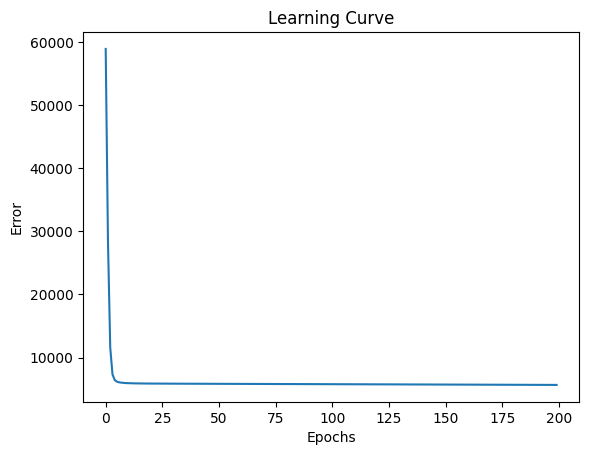

In [7]:
plt.plot(epochs,train_loss)
plt.ylabel("Error"); plt.xlabel("Epochs")
plt.title("Learning Curve")
plt.show()

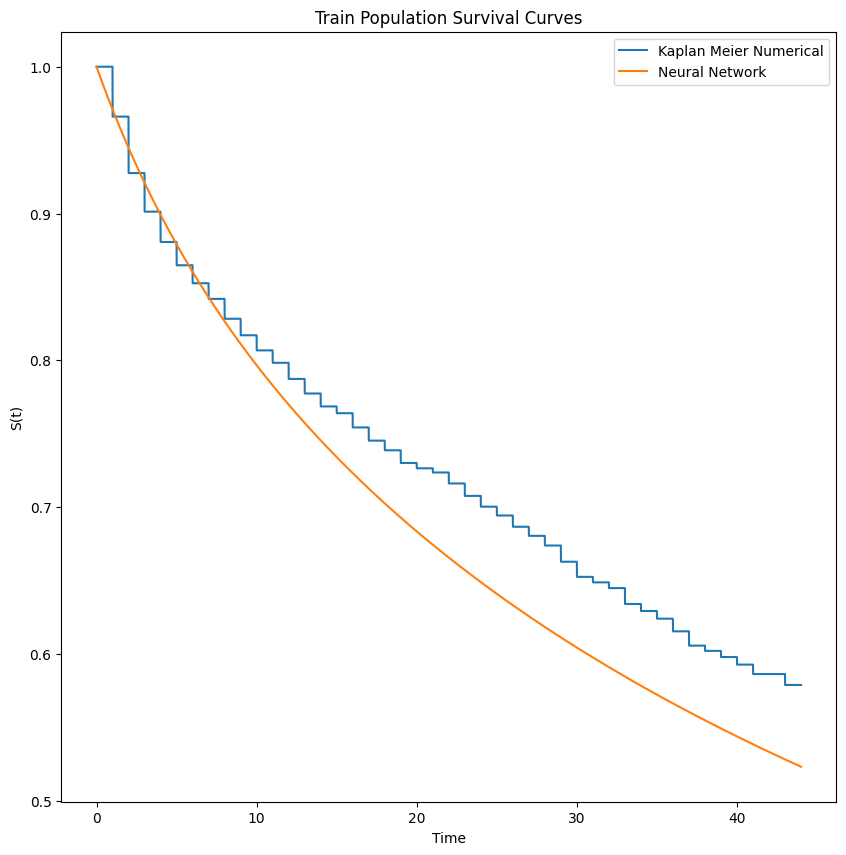

In [8]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_given_x = clf.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Train Population Survival Curves")
plt.show()

Text(0.5, 1.0, 'Individual Survival Curves Train')

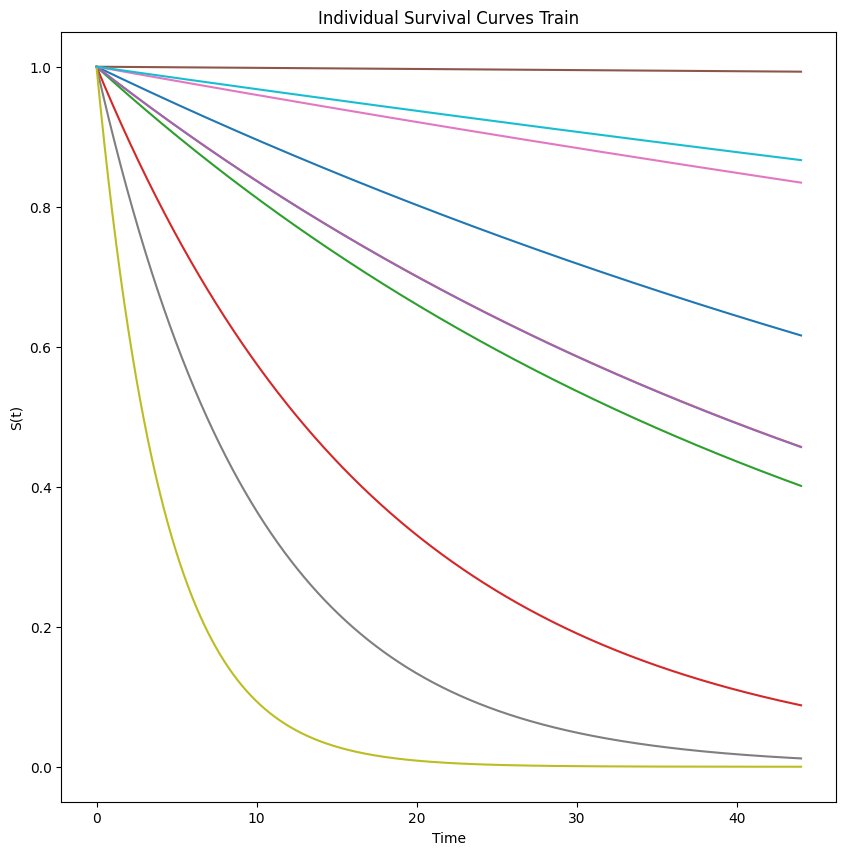

In [9]:
plt.figure(figsize=(10,10))
test_cases = 10
for i in range(test_cases):
    plt.plot(t,St_given_x[i],label="nolegend")
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")

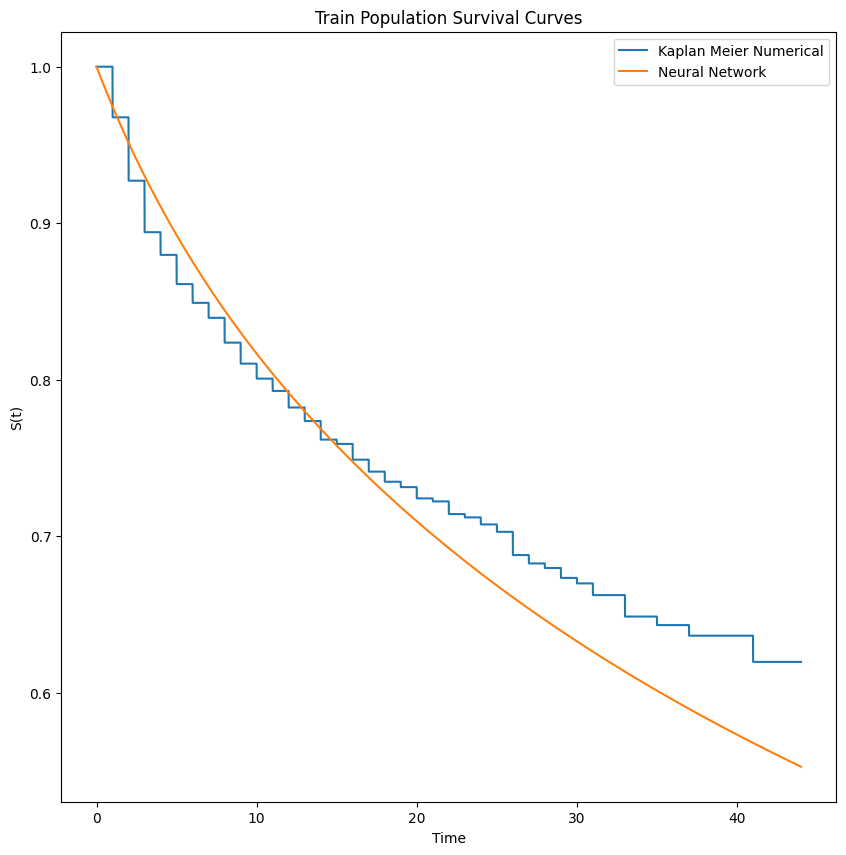

In [10]:
X_test,T_test,E_test = dataloader_test.dataset.tensors
t = torch.linspace(0,T_test.max(),10000)

St_given_x = clf.survival_qdf(X_test,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_test,event_observed=E_test)
St_kmf = kSt_kmf = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Train Population Survival Curves")
plt.show()

In [11]:
print("Train CI",concordance_index(event_times=T_train,predicted_scores=-clf.rate_logit(X_train).detach(),event_observed=E_train))
print("Test CI",concordance_index(event_times=T_test,predicted_scores=-clf.rate_logit(X_test).detach(),event_observed=E_test))

Train CI 0.8015208188250746
Test CI 0.7213111100443689


In [12]:
cph = CoxPHFitter()
df_train,df_test = load_dataframe(ds_name="TRACE",drop_first=True,normalize=True,test_size=0.2)

cph.fit(df_train,duration_col="time",event_col="event",robust=True)

<lifelines.CoxPHFitter: fitted with 1502 total observations, 736 right-censored observations>

In [13]:
print("Train CI",cph.score(df_train,"concordance_index"))
print("Test CI",cph.score(df_test,"concordance_index"))

Train CI 0.746649343872231
Test CI 0.7076876271605408


## auto_LiRPA play!

In [14]:
import auto_LiRPA

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [15]:
bounds = torch.column_stack((X_train.min(0).values,X_train.max(0).values))

In [16]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
nominal_input = torch.zeros((1,input_dims))
# Wrap the model with auto_LiRPA.
model = BoundedModule(clf, nominal_input)
# Define perturbation. Here we add Linf perturbation to input data.
# ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
ptb = PerturbationLpNorm(x_L=bounds[:,0].unsqueeze(0),x_U=bounds[:,1].unsqueeze(0))
# Make the input a BoundedTensor with the pre-defined perturbation.
my_input = BoundedTensor(torch.Tensor(nominal_input), ptb)
# Regular forward propagation using BoundedTensor works as usual.
prediction = model(my_input)
# Compute LiRPA bounds using CROWN
lb, ub = model.compute_bounds(x=(my_input,), method="backward")
output_range_crown_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f"output bounds via CROWN (auto-lirpa): \n{output_range_crown_autolirpa}")

output bounds via CROWN (auto-lirpa): 
[[nan nan]]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.22it/s]


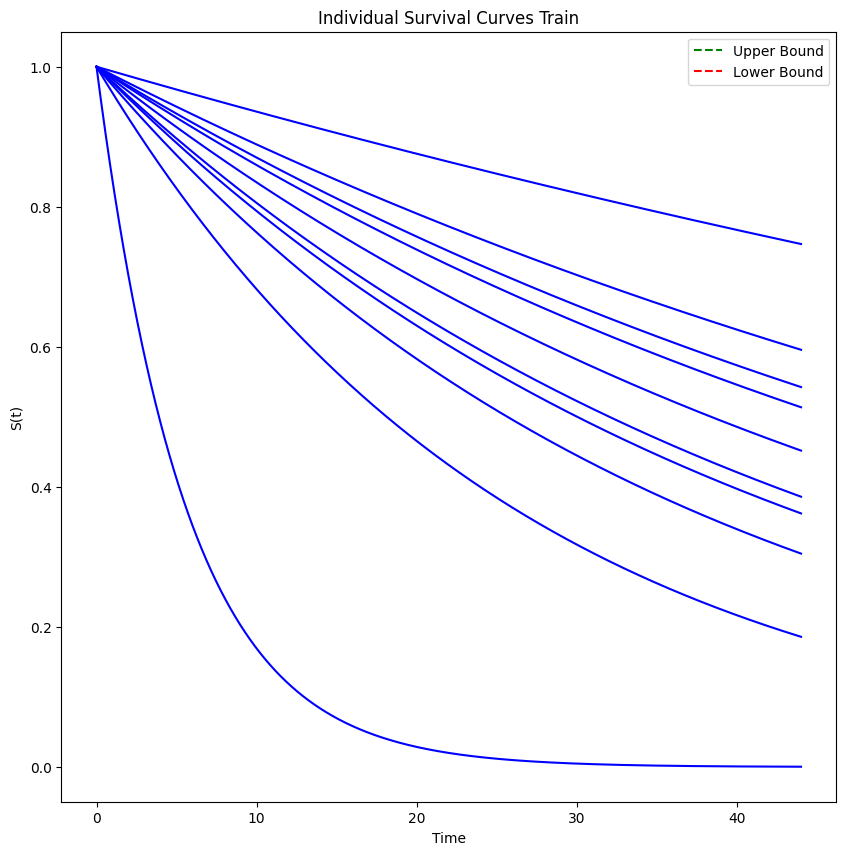

In [17]:
plt.figure(figsize=(10,10))
for Sti in tqdm(St_given_x[:10]):
    plt.plot(t,Sti,'b-',label="_nolegend_")
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")

plt.plot(t,torch.exp(-(output_range_crown_autolirpa[0][0]*t)),'g--')
plt.plot(t,torch.exp(-(output_range_crown_autolirpa[0][1]*t)),'r--')
plt.legend(["Upper Bound","Lower Bound"])

## Autolirpa look at individuals and global

In [18]:
def lower_bound(clf,nominal_input,epsilon):
    # Wrap the model with auto_LiRPA.
    model = BoundedModule(clf, nominal_input)
    # Define perturbation. Here we add Linf perturbation to input data.
    ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
    # Make the input a BoundedTensor with the pre-defined perturbation.
    my_input = BoundedTensor(torch.Tensor(nominal_input), ptb)
    # Regular forward propagation using BoundedTensor works as usual.
    prediction = model(my_input)
    # Compute LiRPA bounds using CROWN
    lb, ub = model.compute_bounds(x=(my_input,), method="backward")
    
    return lb,ub

==========@ eps=0.5==========
Train CI Unperturbed 0.8015208188250746
Train CI Pertubed 0.6196605473387192
==========@ eps=0.1==========
Train CI Unperturbed 0.8015208188250746
Train CI Pertubed 0.7748922254375932
==========@ eps=0.07==========
Train CI Unperturbed 0.8015208188250746
Train CI Pertubed 0.788145407031078
==========@ eps=0.05==========
Train CI Unperturbed 0.8015208188250746
Train CI Pertubed 0.794146413738855
==========@ eps=0.03==========
Train CI Unperturbed 0.8015208188250746
Train CI Pertubed 0.7979369030565668
==========@ eps=0.01==========
Train CI Unperturbed 0.8015208188250746
Train CI Pertubed 0.8006870825680791
==========@ eps=0.001==========
Train CI Unperturbed 0.8015208188250746
Train CI Pertubed 0.801458125105993


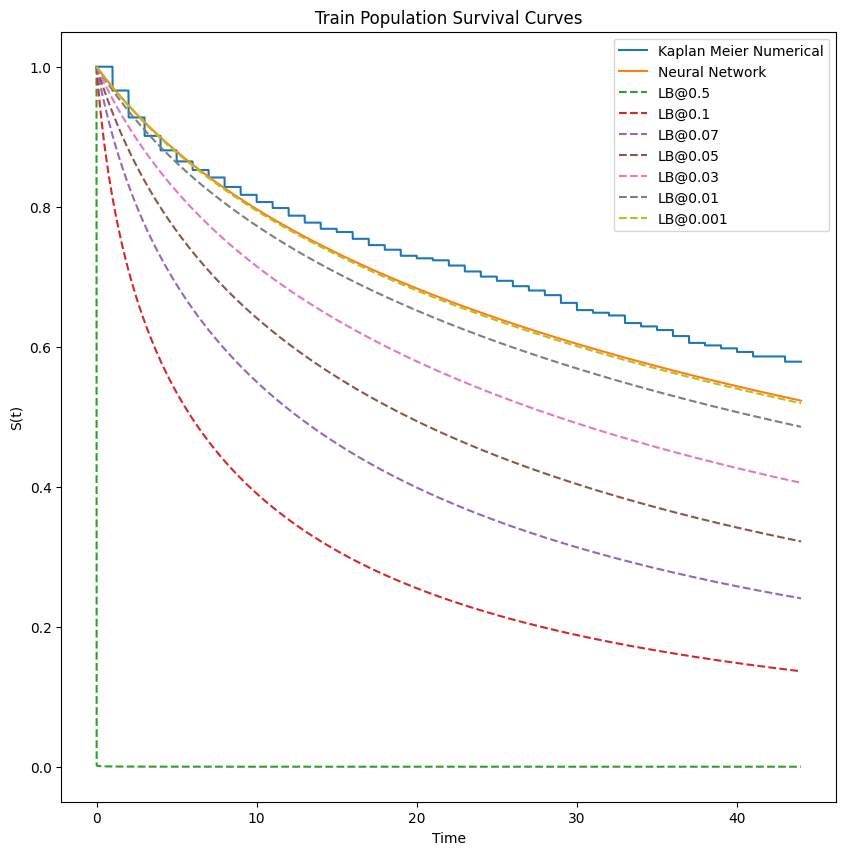

In [19]:
plt.figure(figsize=(10,10))
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_given_x = clf.survival_qdf(X_train,t).detach()
kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf = kmf.predict(times=t.ravel().numpy())

plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))

epsilons = [0.5,0.1,0.07,0.05,0.03,0.01,0.001]
for epsilon in epsilons:
    lb,ub = lower_bound(model,X_train,epsilon)
    ub[ub.isnan()] = 10000
    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Train CI Unperturbed",concordance_index(event_times=T_train,predicted_scores=-clf.rate_logit(X_train).detach(),event_observed=E_train))
    print("Train CI Pertubed",concordance_index(event_times=T_train,predicted_scores=-ub.detach(),event_observed=E_train))
    plt.plot(t,St_lb.detach(),'--')


plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"]+[f"LB@{epsilon}" for epsilon in epsilons])
plt.title("Train Population Survival Curves")
plt.show()

==========@ eps=0.5==========
Train CI Unperturbed 0.7213111100443689
Train CI Pertubed 0.5486428752665903
==========@ eps=0.1==========
Train CI Unperturbed 0.7213111100443689
Train CI Pertubed 0.7044001974997085
==========@ eps=0.07==========
Train CI Unperturbed 0.7213111100443689
Train CI Pertubed 0.713723143811333
==========@ eps=0.05==========
Train CI Unperturbed 0.7213111100443689
Train CI Pertubed 0.717347400615815
==========@ eps=0.03==========
Train CI Unperturbed 0.7213111100443689
Train CI Pertubed 0.7193258265157074
==========@ eps=0.01==========
Train CI Unperturbed 0.7213111100443689
Train CI Pertubed 0.7207487844853007
==========@ eps=0.001==========
Train CI Unperturbed 0.7213111100443689
Train CI Pertubed 0.7211876727265246


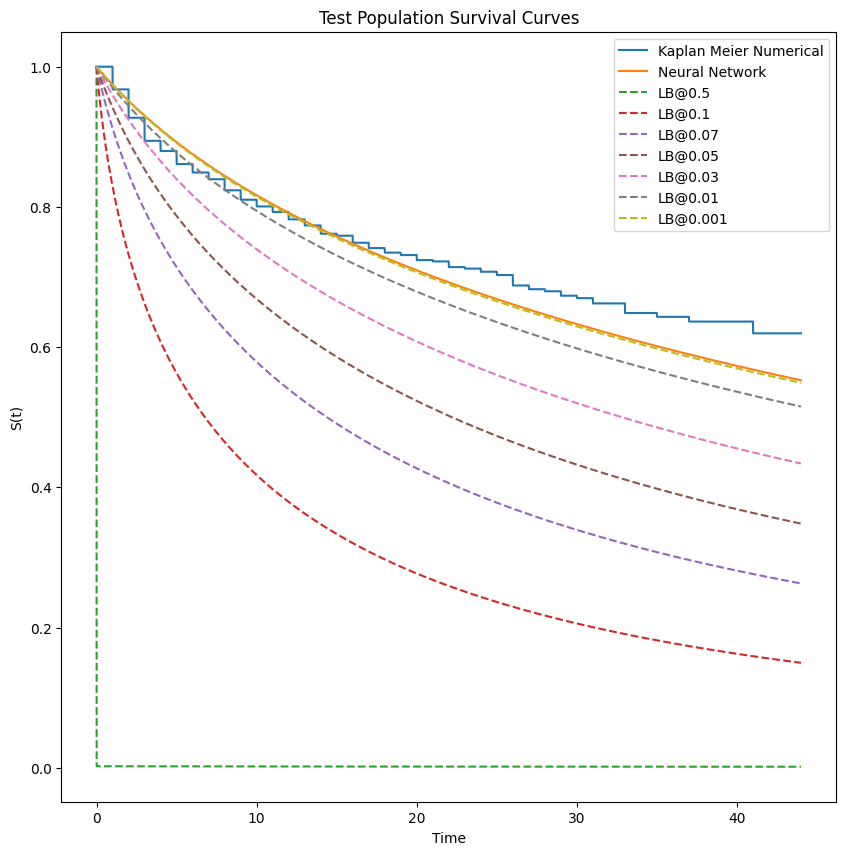

In [20]:
plt.figure(figsize=(10,10))
X_test,T_test,E_test = dataloader_test.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_given_x = clf.survival_qdf(X_test,t).detach()
kmf = KaplanMeierFitter()
kmf.fit(durations=T_test,event_observed=E_test)
St_kmf = kmf.predict(times=t.ravel().numpy())

plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))

epsilons = [0.5,0.1,0.07,0.05,0.03,0.01,0.001]
for epsilon in epsilons:
    lb,ub = lower_bound(model,X_test,epsilon)
    ub[ub.isnan()] = 10000

    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Train CI Unperturbed",concordance_index(event_times=T_test,predicted_scores=-clf.rate_logit(X_test).detach(),event_observed=E_test))
    print("Train CI Pertubed",concordance_index(event_times=T_test,predicted_scores=-ub.detach(),event_observed=E_test))
    plt.plot(t,St_lb.detach(),'--')


plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"]+[f"LB@{epsilon}" for epsilon in epsilons])
plt.title("Test Population Survival Curves")
plt.show()

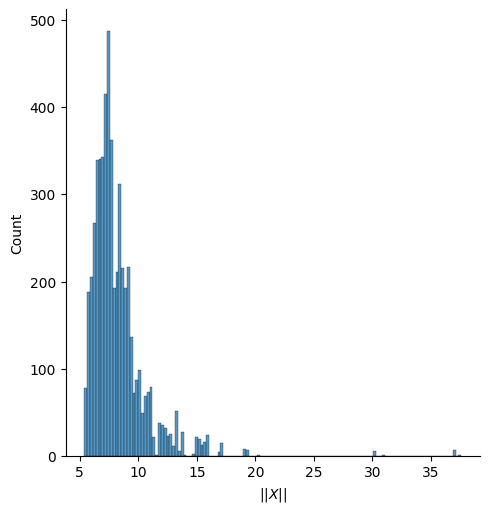

In [21]:
import seaborn as sns
sns.displot(np.linalg.norm(X_train,axis=1))
plt.xlabel("$||X||$")
plt.show()

In [22]:
lb,ub = lower_bound(model,X_test,0.1)
St_lb = torch.exp(-ub*t).detach()

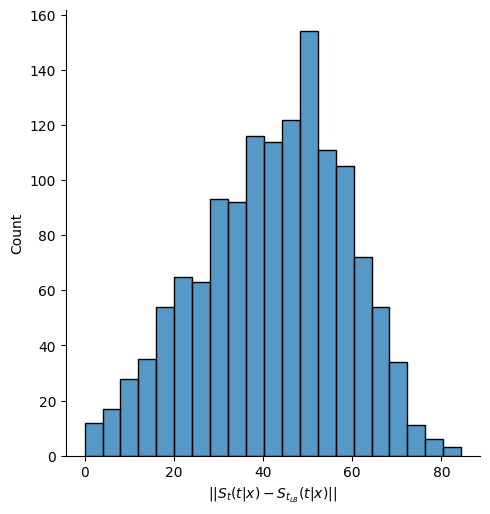

In [23]:
sns.displot(torch.linalg.norm(St_lb - St_given_x,axis=1))
plt.xlabel("$||S_t(t|x) - S_{t_{LB}}(t|x)||$")
plt.show()

<>:2: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_42920\2173741712.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clf(X_train).detach())


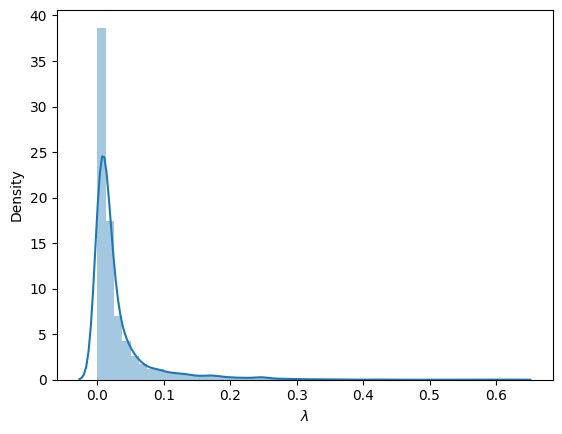

In [24]:
sns.distplot(clf(X_train).detach())
plt.xlabel("$\lambda$")
plt.show()

tensor([0.0000e+00, 1.1905e-05, 1.7217e-05, 2.6213e-03, 1.2903e+00, 2.0527e+00,
        2.8907e+00, 3.1438e+00, 3.4193e+00, 3.7618e+00, 3.7918e+00, 3.9941e+00,
        4.3033e+00, 4.8958e+00, 5.3647e+00, 5.4646e+00, 5.4906e+00, 5.8283e+00,
        5.9397e+00, 6.2371e+00, 6.2371e+00, 6.4603e+00, 6.5432e+00, 6.5500e+00,
        6.7837e+00, 7.1440e+00, 7.5360e+00, 7.5575e+00, 7.7210e+00, 8.2365e+00])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.85it/s]


Text(0.5, 1.0, 'Individual Survival Curves Train')

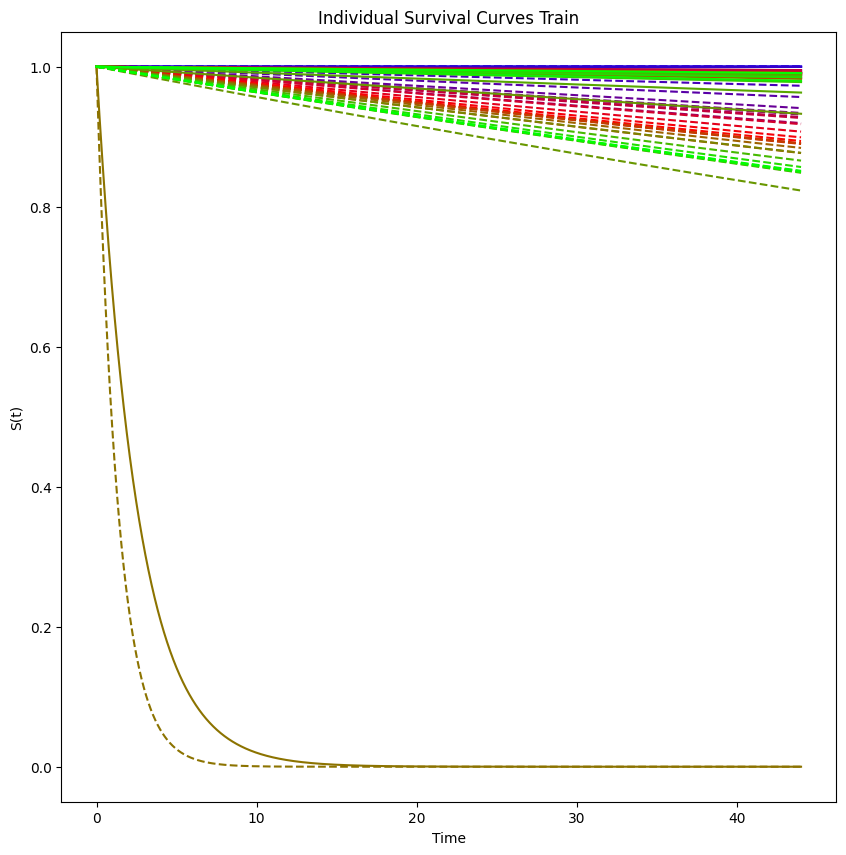

In [25]:
plt.figure(figsize=(10,10))

    
test_cases = 30

colors = list(plt.cm.brg(np.linspace(0,1,test_cases))) + ["crimson", "indigo"]

cases = np.argsort(torch.linalg.norm(St_lb - St_given_x,axis=1))[0:test_cases]
print(torch.linalg.norm(St_lb - St_given_x,axis=1)[cases])

for i,case in enumerate(tqdm(cases)):
    plt.plot(t,St_given_x[case],color=colors[i])
    plt.plot(t,St_lb[case],'--',color=colors[i])
    
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")

tensor([84.4185, 82.5879, 81.0636, 79.1378, 78.2052, 77.7319, 77.4039, 76.5542,
        76.4903, 76.1692, 74.5486, 74.5381, 74.1231, 73.8517, 73.8435, 73.5860,
        73.5198, 72.9692, 72.4797, 72.4023, 72.1556, 72.1401, 72.0889, 71.9407,
        71.8485, 71.8286, 71.4193, 71.2934, 71.1538, 71.1517])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.75it/s]


Text(0.5, 1.0, 'Individual Survival Curves Train')

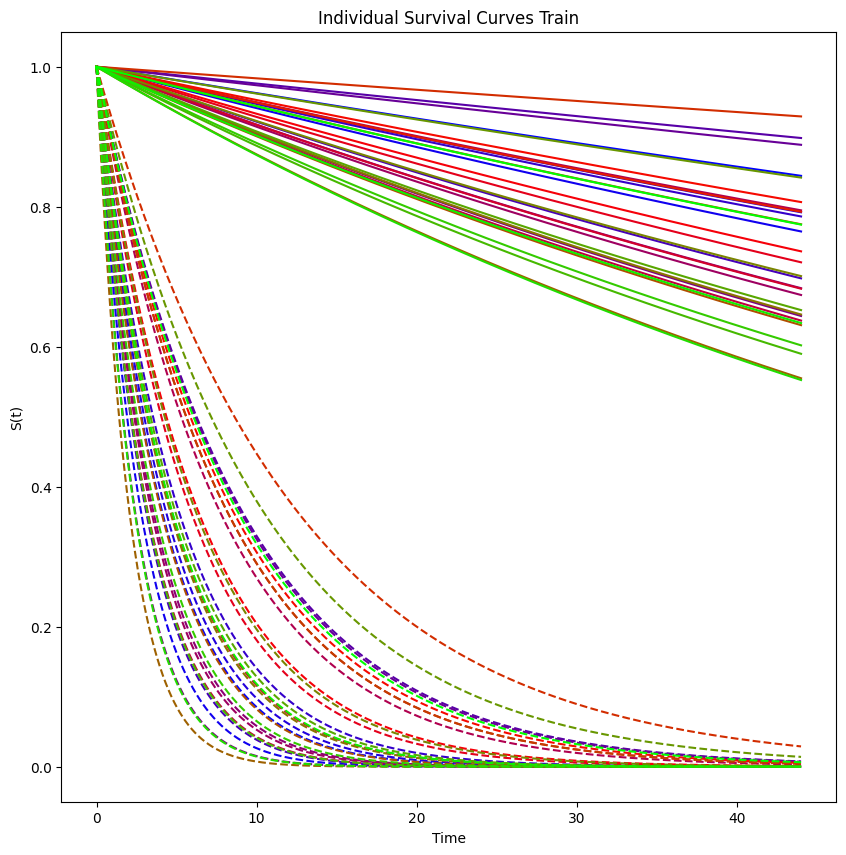

In [26]:
plt.figure(figsize=(10,10))
# lb,ub = lower_bound(model,X_train,0.1)
    
test_cases = 30
cases = torch.flip(np.argsort(torch.linalg.norm(St_lb - St_given_x,axis=1)),dims=(0,))[0:test_cases]
print(torch.linalg.norm(St_lb - St_given_x,axis=1)[cases])
for i,case in enumerate(tqdm(cases)):
    plt.plot(t,St_given_x[case],color=colors[i])
    plt.plot(t,St_lb[case],'--',color=colors[i])
    
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")